In [1]:
import bokeh.plotting as bp
from bokeh.io import show, output_notebook
from bokeh.models import HoverTool
from datashader.bokeh_ext import InteractiveImage
import datashader as ds
import numpy as np
import pandas as pd
import numexpr as ne
import datashader.transfer_functions as tf
from datashader.colors import Greys9, Hot, viridis, inferno, Set1, colormap_select as cm 
from datashader import reductions
from datashader.core import bypixel
from utils import toWebMercator, mega_color
from bokeh.models import HoverTool
from bokeh.tile_providers import WMTSTileSource
import requests
import shutil

In [2]:
file = r'/users/lukestarnes/ADSB/h5/2016-12-07.h5'
store = pd.HDFStore(file)
points = store.select('data',columns=['Lat','Long','Cou','Mil','Man','Type'],
                      where=['Lat>=-90','Lat<=90','Long>=-180','Long<=180']).dropna()
points = points.drop_duplicates()
points['x'],points['y'] = toWebMercator(points['Long'],points['Lat'])

points['Cou'] = points['Cou'].astype('category')
points['Cou'] = points['Cou'].replace([np.inf,-np.inf],np.nan).dropna()

In order to quickly zoom on geographic areas, a reference file is downloaded and imported.

In [4]:
file_url = r'https://gist.githubusercontent.com/graydon/11198540/raw/7c1391f1677c2c1dafe114dc8010bd9b1218e3d0/country-bounding-boxes.py'
r = requests.get(file_url, stream=True)
if r.status_code == 200:
    with open('country_bboxes.py', 'wb') as f:
        r.raw.decode_content = True
        shutil.copyfileobj(r.raw, f)    
from country_bboxes import country_bounding_boxes as cbb

In [5]:
c_bboxes = pd.DataFrame([[k, cbb[k][0], *cbb[k][1]] for k in cbb.keys()], 
             columns=['Code', 'Country', 'Lat1', 'Long1', 'Lat2', 'Long2'])
c_bboxes['x1'], c_bboxes['y1'] = toWebMercator(c_bboxes['Lat1'], c_bboxes['Long1'])
c_bboxes['x2'], c_bboxes['y2'] = toWebMercator(c_bboxes['Lat2'], c_bboxes['Long2'])
c_bboxes.set_index('Code', inplace=True)

In [6]:
def country_to_tuple(cntry):
    # you can provide either the 2 digit code (e.g. US, CN, GB) or the full name (e.g. United States or China)
    s = None
    if cntry in c_bboxes.index: s = c_bboxes.ix[cntry]
    elif cntry in c_bboxes['Country'].values: s = c_bboxes[c_bboxes['Country'] == cntry].squeeze()
    if s is not None: return ((min(s.x1, s.x2), max(s.x1, s.x2)), (min(s.y1, s.y2), max(s.y1, s.y2)))        
    else: return

Here are a bunch of convenience variables for zooming the map to a specific area.  
The format is (X Range, Y Range) so if you do *var then you have the input for x_range and y_range

In [58]:
MaxBounds = ((-20048966.10, 20048966.10), (-20026376.39, 20026376.39))
TwoBounds = ((-20000000, 20000000), (-20000000, 20000000))
DataSetBounds = ((min(points.x),max(points.x)), (min(points.y),max(points.y)))
Top99Bounds = ((np.percentile(points.x,0.1), np.percentile(points.x,99.5)), 
               (np.percentile(points.y,0.1), np.percentile(points.y,99.5)))
USA_CONUS = ((-13884029, -7453304), (2698291, 6455972))
WesternEuro = ((-1181114, 4270391), (3000000, 8081620))
Germany = ((709336, 1600000), (6026907, 7270000))
Chicago = (( -9828281, -9717659), (5096658, 5161298))
Chinatown = (( -9759210, -9754583), (5137122, 5139825))
NewYorkCity = (( -8280656, -8175066), (4940514, 4998954))
LosAngeles = ((-13195052, -13114944), (3979242, 4023720))
Houston = ((-10692703, -10539441), (3432521, 3517616))
Austin = ((-10898752, -10855820), (3525750, 3550837))
NewOrleans = ((-10059963, -10006348), (3480787, 3510555))
Atlanta = ((-9507853,-9274873), (3927030, 4069506))
USA = country_to_tuple('US')
China = country_to_tuple('China')
Russia = country_to_tuple('Russia')
China = country_to_tuple('China')
India = country_to_tuple('India')
Japan = country_to_tuple('Japan')
SKorea = country_to_tuple('S. Korea')
xrange, yrange = USA

## Datashader

The below functions takes a datashader image and puts it on a black background.

In [59]:
def bg(img): return tf.set_background(img,"black")

For datashader, you define your image size and then the points and it computes the pixel value based on the mapping of data to pixels.

Below is the initial setup. Note that Top99Bounds centers the plot on the top 99% of the data (IOW, tosses outliers). 

In [60]:
plot_width, plot_height = 900, 500
glyph = ds.glyphs.Point('x', 'y')
canvas = ds.Canvas(plot_width, plot_height, *Top99Bounds)
agg = bypixel(points, canvas, glyph, reductions.count())
canvas.points(points, 'x', 'y', agg=reductions.count())

<xarray.DataArray (y_axis: 500, x_axis: 900)>
array([[ 0,  0,  0, ..., 16, 29,  0],
       [ 0,  0,  0, ...,  3, 14,  0],
       [ 0,  0,  0, ...,  5, 12,  0],
       ..., 
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int32)
Coordinates:
  * y_axis   (y_axis) float64 -5.364e+06 -5.338e+06 -5.311e+06 -5.285e+06 ...
  * x_axis   (x_axis) float64 -1.657e+07 -1.653e+07 -1.649e+07 -1.646e+07 ...

Below is data for the world.

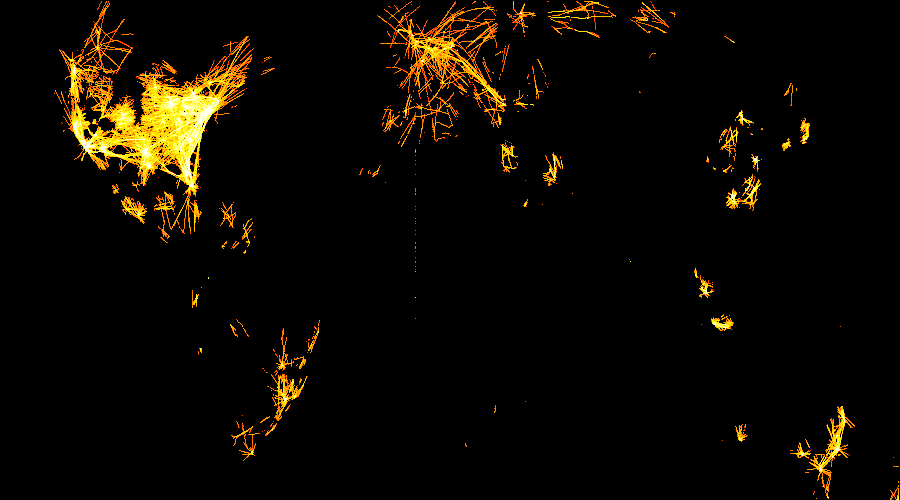

In [61]:
bg(tf.shade(agg, cmap = cm(Hot,0.4)))

And here is the data for the US.

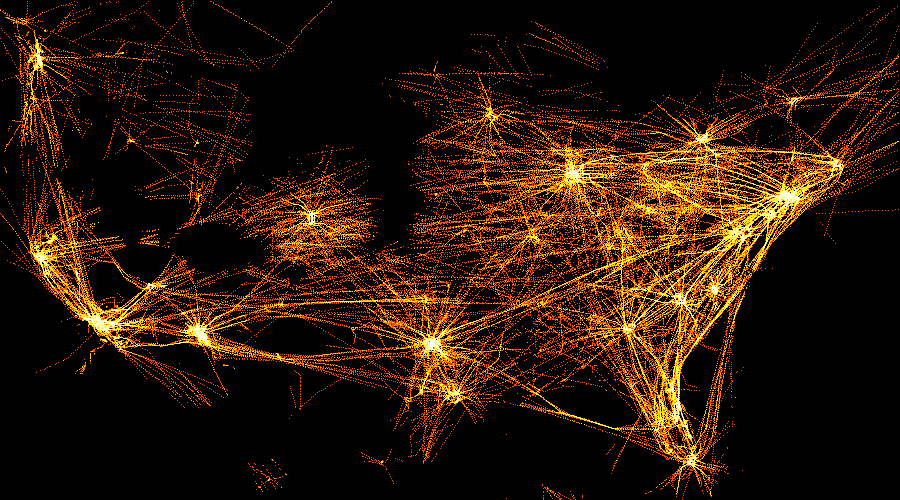

In [62]:
canvas = ds.Canvas(plot_width, plot_height,*USA_CONUS)
agg = bypixel(points, canvas, glyph, reductions.count())
canvas.points(points, 'x', 'y', agg=reductions.count())
bg(tf.shade(agg, cmap = cm(Hot,0.4)))

And Western Europe. 

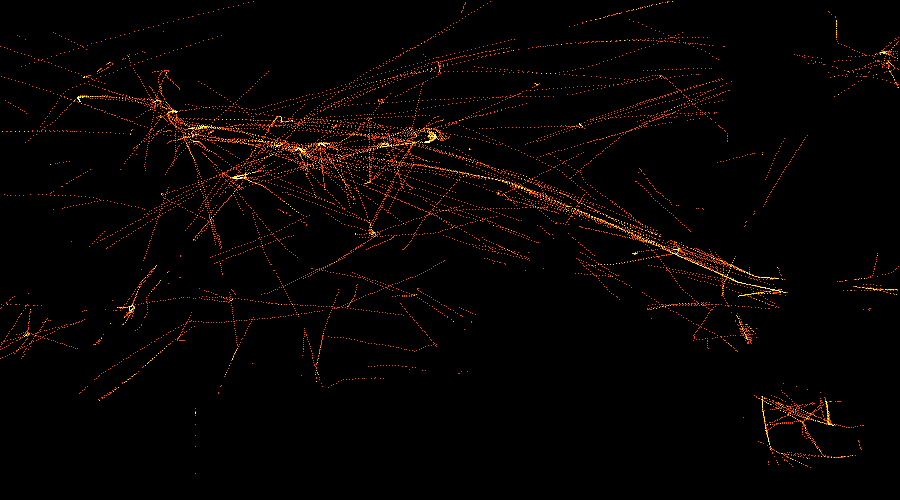

In [63]:
canvas = ds.Canvas(plot_width, plot_height,*WesternEuro)
agg = bypixel(points, canvas, glyph, reductions.count())
canvas.points(points, 'x', 'y', agg=reductions.count())
bg(tf.shade(agg, cmap = cm(Hot,0.4)))

You can also select the data based on an attribute. Here is the data where the aircraft is registered (the Cou field) to the US.

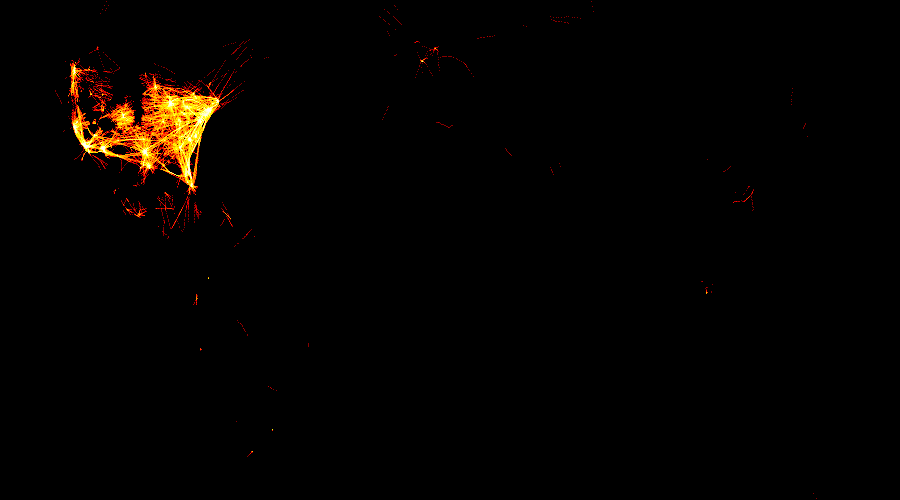

In [64]:
canvas = ds.Canvas(plot_width, plot_height, *Top99Bounds)
agg = bypixel(points, canvas, glyph, reductions.count())
bg(tf.shade(canvas.points(points, 'x', 'y', ds.count_cat('Cou')).
            sel(Cou='United States'), Hot))

Below colors the plots based on the country of registry.

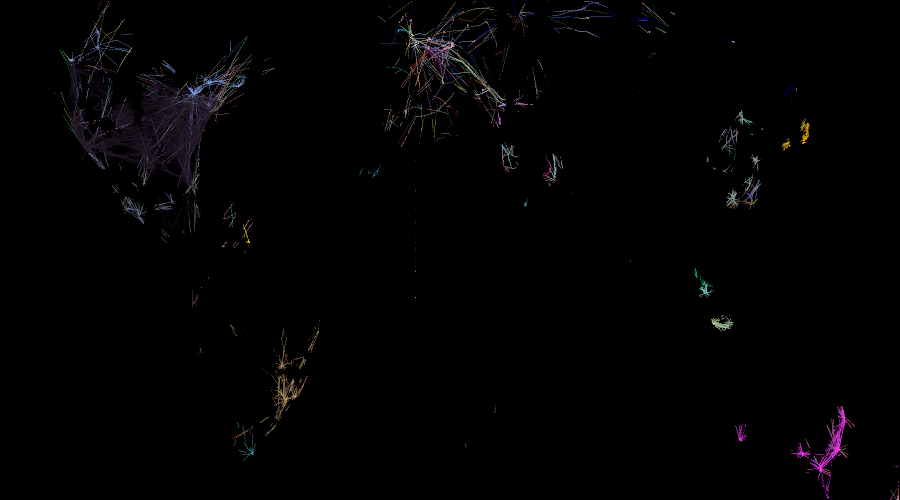

In [81]:
np.seterr(divide='ignore', invalid='ignore')
def create_image(x_range, y_range, w, h, spread=0):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    pts = cvs.points(points, 'x', 'y', ds.count_cat('Cou'))
    img = tf.shade(pts, color_key=mega_color)
    if spread: img = tf.spread(img,px=spread)
    return bg(img)
create_image(*Top99Bounds,plot_width, plot_height)

## Datashader with Bokeh

In [9]:
output_notebook()

Loading BokehJS ...

Below is a Datashader image being shown within Bokeh. This relies on the InteractiveImage function to tie the two together. You can also see the nice map tile (map tiles are one of the nice things Bokeh brings to the table).

In [29]:
np.seterr(divide='ignore', invalid='ignore')
xr, yr = USA_CONUS
p = base_plot(xrange=xr,yrange=yr,bok_cir=False) 
def image_callback(x_range, y_range, w, h):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    pts = cvs.points(points, 'x', 'y')
    img = tf.shade(pts, cmap=Set1)
    return img
 
InteractiveImage(p, image_callback)

As a comparison, here is the same plot using just Bokeh.

In [106]:
def base_plot(tools='pan,wheel_zoom,box_zoom,reset',webgl=False,
              xrange=xrange,yrange=yrange,plot_width=int(900),plot_height=int(500),
             bok_cir = True):
    p = bp.figure(tools=tools,
                  plot_width=plot_width, plot_height=plot_height,
                  x_range=xrange, y_range=yrange, outline_line_color=None,
                  min_border=0, min_border_left=0, min_border_right=0,
                  min_border_top=0, min_border_bottom=0, webgl=webgl)
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    if bok_cir:
        p.circle(x=points.x,y=points.y,color='red', size=2, alpha=0.4) 
    cartocdn = "http://a.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}.png"
    tile_renderer = p.add_tile(WMTSTileSource(url=cartocdn)) 
    tile_renderer.alpha=0.9
    return p

xr, yr = USA_CONUS
p = base_plot(xrange=xr,yrange=yr) 
show(p)

Below you can see the data with tooltips when you hover. Currently Hover is [not supported](https://github.com/bokeh/datashader/issues/91) when using Datashader, so this plot is using Bokeh glyphs.

In [79]:
def filter_plot(xrange, yrange,plot_width=int(900),plot_height=int(500),webgl=False):
    filtered = points[(points.x>xrange[0]) & (points.x<xrange[1]) 
                      & (points.y>yrange[0]) & (points.y<yrange[1])]
    source = bp.ColumnDataSource(data=filtered)
    hover = HoverTool(tooltips = [('Lat', '@Lat'),
                                  ('Long', '@Long'),
                                  ('Country', '@Cou'),
                                  ('Military', '@Mil'),
                                  ('AC Mfr/Type', '@Man @Type')])
    p = bp.figure(tools='pan,wheel_zoom,reset,box_zoom,save', 
                  x_range=xrange,
                  y_range=yrange,
                  plot_width=plot_width, plot_height=plot_height,
                  outline_line_color=None,
                  min_border=0, min_border_left=0, min_border_right=0,
                  min_border_top=0, min_border_bottom=0,webgl=webgl)
    p.add_tools(hover)
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.circle('x','y',source=source,color='white',size=4, alpha=0.4) #color=color, 
    cartocdn = "http://a.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}.png"
    tile_renderer = p.add_tile(WMTSTileSource(url=cartocdn)) 
    tile_renderer.alpha=0.9
    print('%i points' % len(filtered))
    return p
show(filter_plot(*Atlanta))

1230 points


Below is another Bokeh plot where the color is based on the aircraft manufacturer. 

In [82]:
tmp = points.copy()
tmp['dummy'] = tmp.index
keys = tmp.groupby('Man').count()['dummy'].sort_values(ascending=False)[:10].index
color_mapper = dict.fromkeys(keys)
color_list = Hot
for i, k in enumerate(keys):
    color_mapper[k] = Hot[i]
for k in points.Man.unique():
    if k not in keys:
        color_mapper[k] = 'cyan'
print('Top 10 manufactures are colored as shown below. All other manufactueres are colored cyan.')
print(['%s: %s' % (k, color_mapper[k]) for k in keys])

Top 10 manufactures are colored as shown below. All other manufactueres are colored cyan.
['Boeing: black', 'Airbus: maroon', 'Bombardier: darkred', 'Embraer: red', 'Cessna: orangered', 'McDonnell Douglas: darkorange', 'Gulfstream Aerospace: orange', 'Piper: gold', 'Dassault: yellow', 'Beech: white']


In [83]:
def filter_plot(xrange, yrange,plot_width=int(900),plot_height=int(500),webgl=False):
    filtered = points[(points.x>xrange[0]) & (points.x<xrange[1]) 
                      & (points.y>yrange[0]) & (points.y<yrange[1])]
    color = filtered.Man.map(color_mapper)
    p = bp.figure(tools='pan,wheel_zoom,reset,box_zoom,save', 
                  x_range=xrange,
                  y_range=yrange,
                  plot_width=plot_width, plot_height=plot_height,
                  outline_line_color=None,
                  min_border=0, min_border_left=0, min_border_right=0,
                  min_border_top=0, min_border_bottom=0,webgl=webgl)
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.circle(filtered.x,filtered.y,color=color,size=4, alpha=0.4) #color=color, 
    cartocdn = "http://a.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}.png"
    tile_renderer = p.add_tile(WMTSTileSource(url=cartocdn)) 
    tile_renderer.alpha=0.9
    print('%i points' % len(filtered))
    return p
show(filter_plot(*WesternEuro))

15641 points
